# Multi-armed bandits with OpenAI

In [43]:
import gym
import gym_bandits   # see https://github.com/JKCooper2/gym-bandits

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from itertools import cycle
from collections import defaultdict

Note: OpenAI doesn't have a multi-armed bandit environment so I'm using this one from https://github.com/JKCooper2/gym-bandits. 

So we end up with these Bandits:

In [3]:
print(f"we've got {len(gym.envs.registry.all())} environments, with the Bandit ones being:")
[env for env in list(gym.envs.registry.all()) if "bandit" in str(env).lower()]

we've got 805 environments, with the Bandit ones being:


[EnvSpec(BanditTenArmedRandomFixed-v0),
 EnvSpec(BanditTenArmedRandomRandom-v0),
 EnvSpec(BanditTenArmedGaussian-v0),
 EnvSpec(BanditTenArmedUniformDistributedReward-v0),
 EnvSpec(BanditTwoArmedDeterministicFixed-v0),
 EnvSpec(BanditTwoArmedHighHighFixed-v0),
 EnvSpec(BanditTwoArmedHighLowFixed-v0),
 EnvSpec(BanditTwoArmedLowLowFixed-v0)]

## OpenAI gym basics

Making an env like so:

In [4]:
env = gym.make('BanditTenArmedGaussian-v0')

WARN: Environment '<class 'gym_bandits.bandit.BanditTenArmedGaussian'>' has deprecated methods '_step' and '_reset' rather than 'step' and 'reset'. Compatibility code invoked. Set _gym_disable_underscore_compat = True to disable this behavior.


See the action space, which for our ten armed bandits is just a number from 0 to 9, representing each bandit - the action is just passing in which bandit to use, and the observation_space is just a number `0` - for in this simple game a game is just one play, so there is no observation per se, just a reward, which could be any number, though in practice with a real bandit it would have a upper bound:

In [5]:
env.action_space, env.observation_space, env.reward_range

(Discrete(10), Discrete(1), (-inf, inf))

the gym has a built in method `env.action_space.sample` to randomly sample from the action space. So for the 10 bandits are actions look like:

In [6]:
[env.action_space.sample() for _ in range(15)]

[5, 0, 3, 3, 7, 9, 3, 5, 2, 4, 7, 6, 8, 8, 1]

lets take a look at the probability distribution for the bandits:

In [7]:
env.unwrapped.p_dist

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

the 1's in the probablity distrubution `p_dist` tells us that each bandit will always pay out. If the p_dist had numbers less than one, like 0.5, then we would have a 50% probablity of a payout. So lets take a look at the actual payouts - the reward distribution `r_dist` tells us the mean and the std dev of the payments for each bandit:

In [8]:
actual_rewards = env.unwrapped.r_dist
actual_rewards[:4]

[[-0.8366567978030726, 1],
 [-0.6444026326181792, 1],
 [0.7587942152592464, 1],
 [0.4860381049569645, 1]]

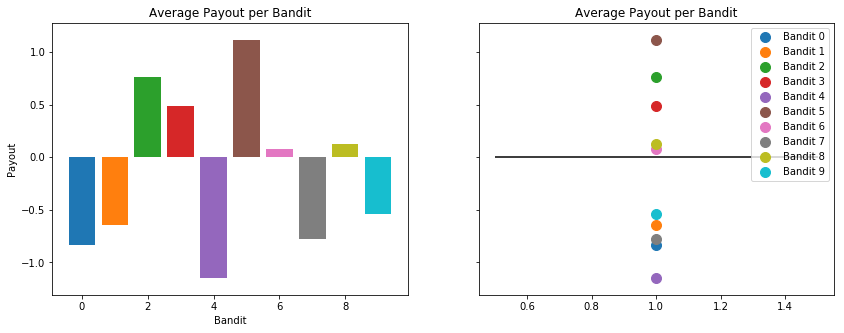

In [9]:
fig, axes = plt.subplots(1,2, figsize=(14,5), sharey=True)

axes[0].set_title("Average Payout per Bandit")
axes[0].set_xlabel("Bandit")
axes[0].set_ylabel("Payout")
for i, r in enumerate([r for r,_ in actual_rewards]):
    axes[0].bar(i, r, label=f"Bandit {i}")

axes[1].set_title("Average Payout per Bandit")
for i, r in enumerate([r for r,_ in actual_rewards]):
    axes[1].scatter(1, r, label=f"Bandit {i}", s=100)
axes[1].hlines(0, 0.5,1.5)
axes[1].legend();

## The basics of an openai env are:

- **observations** - an object giving the state of the environment, like position of pieces on a board, velocities, camera data, etc
- **reward** - a float number the reward after an action, generally higher the better, with +ve being good and -ve being bad
- **done** - many environments have an end state, so this tells us if we're finished (agent died, game ended, etc)
- **info** - diagnostic info

So lets take a look at our multi-armed bandits, initially choosing each one randomly:

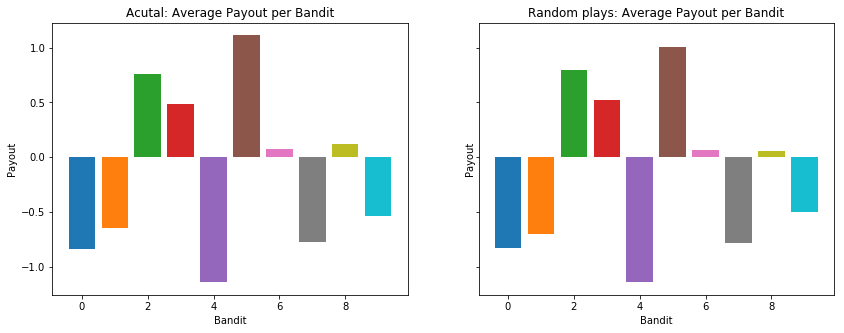

In [17]:
bandits = defaultdict(list)
observation = env.reset()
rewards = []

for i_episode in range(5000):
    action = env.action_space.sample() # selecting a random bandit  
    observation, reward, done, info = env.step(action) # pulled the lever
    bandits[action].append(reward)
    rewards.append(reward)

env.close()

fig, axes = plt.subplots(1,2, figsize=(14,5), sharey=True)

axes[0].set_title("Acutal: Average Payout per Bandit")
axes[0].set_xlabel("Bandit")
axes[0].set_ylabel("Payout")
for i, r in enumerate([r for r,_ in actual_rewards]):
    axes[0].bar(i, r, label=f"Bandit {i}")
    
axes[1].set_title("Random plays: Average Payout per Bandit")
axes[1].set_xlabel("Bandit")
axes[1].set_ylabel("Payout")
for i in range(10):
    axes[1].bar(i, np.mean(bandits[i]), label=f"Bandit {i}")

So we can see that we have the same distribution as the actual reward distribution. Our random strategy has a pretty dismal net payout:

In [19]:
total_reward = 0

for bandit, plays in bandits.items():
    total_reward += np.sum(plays)

print(total_reward)

-739.4477665271686


the random strategy loses us a lot of money! So moving on to a better one:

## Epsilon Greedy

First up, a helper func to find the best bandit

In [22]:
def find_best_bandit(bandits=bandits):
    """takes in a dictionary of bandits and returns the best bandit"""
    best_bandit = None
    best_score = -10000
    for bandit, plays in bandits.items():
        if np.sum(plays) > best_score:
            best_bandit = bandit
            best_score = np.sum(plays)
    return best_bandit

find_best_bandit()

5

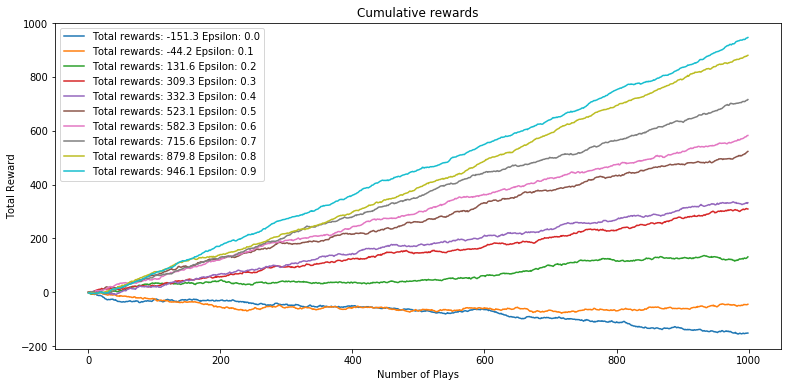

In [23]:
def play_bandits(epsilon=0.9, episodes=1000):
    """simulation of playing bandits, returns rewards and a dict of bandits"""
    bandits = defaultdict(list)
    rewards = []
    observation = env.reset()

    for i in range(episodes):
        # slowly increase epsilon to its max
        if np.random.random() < (epsilon - epsilon**(i/3)):
            action = find_best_bandit() # choose best bandit
        else:
            action = env.action_space.sample() # selecting a random bandit

        observation, reward, done, info = env.step(action) # pulled the lever
        bandits[action].append(reward)
        rewards.append(reward)
    
    env.close()
    
    return rewards, bandits

plt.figure(figsize=(13,6))
for epsilon in np.arange(0, 0.91, step=0.1):
    r, b = play_bandits(epsilon)
    plt.plot(np.cumsum(r), label=f"Total rewards: {np.sum(r):5.1f} Epsilon: {epsilon:0.2}")
plt.title("Cumulative rewards")
plt.xlabel("Number of Plays")
plt.ylabel("Total Reward")
plt.legend();

doing a number of runs cause science not anecdote:

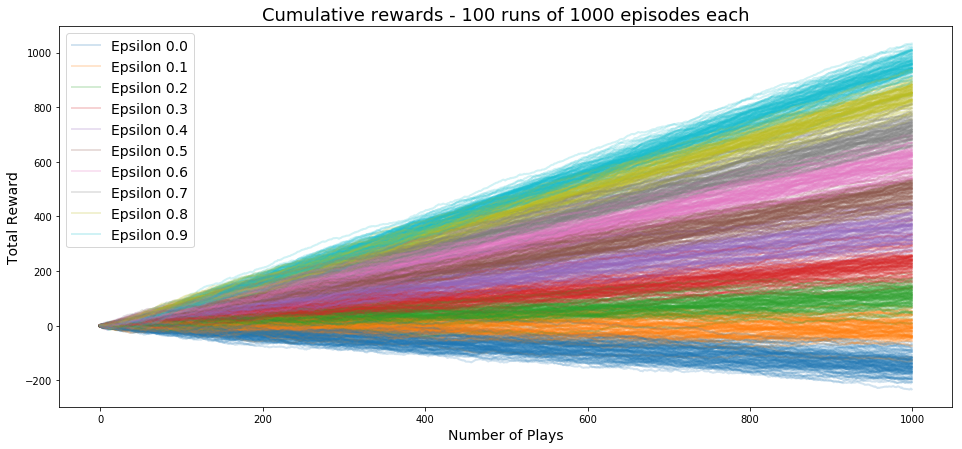

In [87]:
episodes, sims = 1000, 100

plt.figure(figsize=(16,7))
for sim in range(sims):
    for epsilon in np.arange(0, 0.91, step=0.1):
        r, b = play_bandits(epsilon, episodes=episodes)
        plt.plot(np.cumsum(r), alpha=0.2, lw=2,
                 label=f"Epsilon: {epsilon:0.2}")
plt.title(f"Cumulative rewards - {sims} runs of {episodes} episodes each", fontsize = 18)
plt.xlabel("Number of Plays", fontsize = 14)
plt.ylabel("Total Reward", fontsize = 14)
plt.legend([f"Epsilon {epsilon:.1f}" for epsilon in np.arange(0, 0.91, step=0.1)], fontsize = 14);

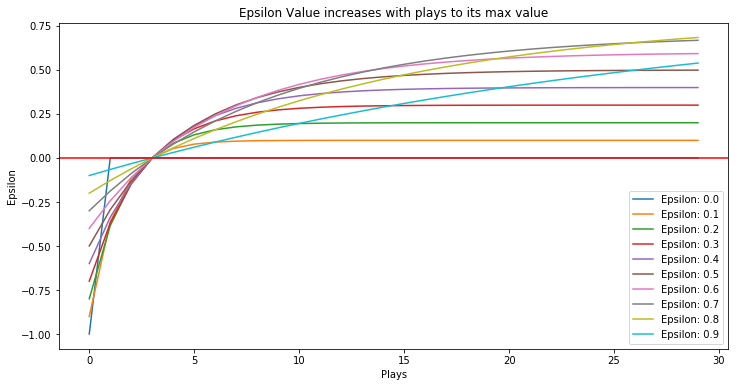

In [89]:
plt.figure(figsize=(12,6))
for epsilon in np.arange(0, 0.91, step=0.1):
    plt.plot([epsilon - epsilon**(i/3) for i in range(30)], 
             label=f"Epsilon: {epsilon:0.2}")
plt.title("Epsilon Value increases with plays to its max value")
plt.ylabel("Epsilon")
plt.xlabel("Plays")
plt.legend();